In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from scipy.stats import norm
from statsmodels.stats.proportion import confint_proportions_2indep
from statsmodels.stats.proportion import proportions_ztest
# import the beta function from scipy.special
from scipy.special import beta as beta_function

# AB Test Methodologies

## General Structure of Standard AB test between a Control C and a Variant A

We have an existing journey which has a completion rate of x% , currently x=20%

We are going to keep 90% of the traffic on the legacy/existing pages as a controld group and test n variants $A$ We want to make sure the new proposed CX is not worse or better than the control, at which point we will switch all traffic to the variants, then rate the variants against each other.

The type of AB test where one want to see whether somethig new is not "making things worse" i.e. somehow degrading the experience is usually called a "non inferiority test" (see below)

## Null Hypothesis Significance Testing (NHST) Methodology

### Framing of the problem using Random Variables

The analysis will consider 2 Bernoulli Random Variables $X_C$ and $X_A$ from which we will draw repeadetly (simulating presenting the new CX repeatedly to a bunch of end users)

$X_C$ being the UX and Bernoulli RV presented to control control group  $X_A$ being the variant A presented. They are both assumed to have for codomain $\mathcal{X}_C=\mathcal{X}_A=\{0,1\}$ that is a boolean i.e. it converts or does not convert. Here "convert" means the user perform the action they intended to do vs. abandoning the journey, e.g. create a passkey. There a possiblty with a techincal failure but this would not be their choice so it woudl be counted as a success for the purpose of this AB test.

To assess this convertion rate we define a new random varaibles we will call"sample proportions"  which is the sum of n instances of the Bernoulli ones defined above, divided by n. For this "sample proportion" Let's using the notation  $\hat{p}_C$ and $\hat{p}_A$ for the control and the variant respectively , defined as

 $ \hat{p_C}=\frac{1}{n}\sum_1^n X_{Ci}$ and 
 $ \hat{p_A}=\frac{1}{n}\sum_1^n X_{Ai}$
 
 each sample proportion can be interprested as 2 things :

* $ \hat{p_C}$ and  $ \hat{p_A}$ can be interpresetd as ordinary random variables with codomain $\{0,\frac{1}{n},\frac{2}{n},...\frac{n}{n}\}$
* $\hat{p_C}$ and  $ \hat{p_A}$ can also be intepreteda as estimators of the expected value $E(p_C)$ and $E(p_A)$ , in general regardless of whether it is a control or a variant $E(\hat{p}) \rightarrow E(p)$ because of the law of large numbers applied to a Bernoulli/Binomial.

An estimator is a function from the n-cartesian product of the space of realizations of X (on itself n times)  to the domain of the parameter of interest, if we  use the notation codomain(X) = $\mathcal{X}$, it is then a maaping from $\mathcal{X}^n$ to some real value for a paraemter of original random variable X, in this case $\hat{p}_A: \mathcal{X}^n \rightarrow \{0,\frac{1}{n},\frac{2}{n},...,\frac{n}{n}\}$ Because it it is a sum of Bernoullis, the estimator RV follows binomial distribution centered on the expected value. It is always true that a discrete binomial distirubtion can be approximated by a contunous gaussian as n grows (clipping the tails)

Note that for a Bernoulli random variable $X$ we have $Var(X) = p (1-p)$ and therefore 
  
$Var(\frac{1}{n}\sum_1^n X_i) = \frac{1}{n^2}Var(\sum_1^n X_i)$

$Var(\frac{1}{n}\sum_1^n X_i) = \frac{1}{n^2}n(p(1-p))$


$Var(\frac{1}{n}\sum_1^n X_i) = \frac{1}{n}(p(1-p))$

so $\boxed{Var(\hat{p})= \frac{p(1-p)}{n}}$



### Estimators

To make the rest of the discussion easier to read  we are going to define the difference in estimator $\hat{p_A}$ and $\hat{p_C}$ as $\hat\Delta = \hat{p_A} - \hat{p_C}$ which is also an estimator of the expected value of random varaible $\Delta = p_A - p_C$


### Null Hypothesis (H₀):


As we said earlier the  first possible "effect" is if the new passkey creation UX degrades the overall UX so much that it may impacts our other business metrics. In the classical framing of a non-inferiotity test, the  Null Hypothesis is the "bad thing" we are tryigng to reject in our case it would mean : "some degration".
"some degration" can be described with a simple inequality like  $E(p_A) \le E(p_C) - \epsilon $ where $\epsilon$ is a tiny degradation we would find acceptable for instance 0.05 (5%).

We will rewrite

$H_0$ as $\boxed{H_0 = E(\Delta) \leq -\epsilon}$




### Alternative Hypothesis (H₁):
 The conversion rate for the variant is higher than $\boxed{E(\Delta) > -\epsilon}$



### Boundary Hypothesis

Below we will make use of the hyoptheis that the difference in conersiohn is exactly the snall accetable one  that is

$\boxed{E(\Delta) = -\epsilon}$


#### Numerical example 

Each realization is given after each experience by the folowing counts

$n_C$: Number of visitors in the control group

$x_C$ : Number of conversions observed (realization) in a given control group

$n_A$: Number of visitors in the variant group

$x_A$ : Number of conversions observed (realization) in the variant group

$\hat{\Delta(w)}$ the observed value of the difference between the proportions

$\epsilon$ : accetable degradation in the difference between the proportions



In [30]:
control_group_conversion_rate = 0.2
nC = 7000
xC_realization = nC * control_group_conversion_rate
nA = 1000
xA_realization = 200
epsilon = 0.03
alpha = 0.05
hatpC_realization = xC_realization / nC
hatpA_realization = xA_realization  / nA
hatDelta_realization = hatpA_realization - hatpC_realization

print(f"Realization of difference in conversion rate estimator: {hatDelta_realization:.4f}")
print(f"Control group realization of conversion rate estimator: {hatpC_realization:.4f}")
print(f"Treatment group realization of conversion rate estimator: {hatpA_realization:.4f}")

Realization of difference in conversion rate estimator: 0.0000
Control group realization of conversion rate estimator: 0.2000
Treatment group realization of conversion rate estimator: 0.2000


### Standard Deviation of the estimator $\hat{\Delta}$ (a.k.a Standard Error in frequentist/classic statistics)

The NHST methodolgy involve computing first an estimatation of the standard deviation for the estimator $\hat{\Delta}$, then to see how likely it then comparing it with the actual values we get from the difference in proportion in the experiment, then based on this decide if the difference observed is far enough (or close enough) to the theoritical value to reject or not reject the hypothesis based on some accpeted risks in the deicison rules (power, confidence internval)

There are several methos to conpute the standard varatio of the estimator of the difference of proporition



#### If the null hypotehsis is "no effect", use the Wald pooling method:

If instead of "non inferiority" the null hypothesis $H-0 is "no effect", we can record the observed conversion rates (estimators) for each proportion then  combine (pool) as under this very specific null hypothesis they have the exact same expected value so a larger sample created through pooling is a better estimator of the true value, whatever it is.

the realization of $\hat{p}_A$  is $(\hat{p}_A(\omega) = \frac{x_A}{n_A})$

the associated realization of $\hat{p}_C$ is  $(\hat{p}_C(\omega) = \frac{x_C}{n_C})$

Then there is a theoritical estimator for the combine exeprience IF the null hypothesis was holding and there was not difference A and the control there woudl be a random variable for the estimator of both being pooled

$\hat{p}(\omega_{pool}) = \frac{x_A + x_V}{n_A + n_C}$

Then we try to compute the variance standard deviation of the difference between the conversion rate of the control vs. the variance. The variance of the difference beteww the 2 proportion is the sum of their variance, so

$Var(\hat{p}_A - \hat{p}_C ) = Var(\hat{p}_C) + Var(\hat{p}_A)$

Here there is the first "sleight of hand", we dont really know the true mean of those estimators, but appplying a "trick" called the plugs in (it is actually called the plug in principle) the *realization* of the pooled esimtator is used as if it was the true underlying value( so called population true parameter ) in the formula for the standard deviation and then we use the resulitng standard deviation it as THE standard deviation of the estimators, from that SD then we compute a z-score. The justification is a bit hand wavy and assume "converge" if many expeirments are run which is obviously questionnable on a single experiement in order to make a decision.

Also because both $\hat{p_C}$ and $\hat{p_A}$ are Bernoulli RV, and using this "plug in " principal; we compute the sum of variance of the estimators also using the pooled sample reading as:

$Var(\hat{p}_A - \hat{p}_C ) = \frac{\hat{p}(\omega_{pool})(1- \hat{p}(\omega_{pool}))}{n_A} + \frac{\hat{p}(\omega_{pool})(1- \hat{p}(\omega_{pool}))}{n_C} = \hat{p}(\omega_{pool})(1- \hat{p}(\omega_{pool})) (\frac{1}{n_C} + \frac{1}{n_A})$

and the standard error which is just the standard deviation of the same quantity  also using the plug in principl the standard devation of the estimators that statisticain call "standard error" is

$\boxed{WaldPooled SE = \sqrt{\hat{p}(\omega_{pool})(1- \hat{p}(\omega_{pool})) (\frac{1}{n_C} + \frac{1}{n_A})}}$

this is sometimnes called "pooled standard error" or "standard error of the difference between two independent proportions"

From this we conmpute the z-score whuich is a dimenionless value counting the number of standard devaition that the difference observed is from the theoritical difference which shoiuld be zero under the null hypothesis (approximated by the pooled one, sktechy). So a simple ivisino of the observed devation over teh standard deviation of hte diference

$z= \frac{\frac{x_A}{n_A} - \frac{x_C}{n_C}}{SE}$



#### When null hyopthesis is "non inferiority", use the Wald Unpooled Standard Error:

If the null hypotheis is not "no effect" we cannot assume that each sample is drawn from teh same random variable, we actually explicitely say it is not because of the epsilon among other thing. So the first quick and dirt approch is just to sum the separate variances (see above variance of Bernoulli) as variances are additive when random variable are added  or substracted in our case, and are assymed to be independent, then take the square roo t pf that sum to get to a standard deviation:

$\hat{WaldUnpooledSE} = \sqrt{\frac{\hat{p_A(w)}(1-\hat{p_A(w)})}{n_A} + \frac{\hat{p_C(w)}(1-\hat{p_C(w)})}{n_C}}$

Note that we should be using hte expected value of $E(p_A)$ and $E(p_B)$ in the formula but we don't know them, so we use the so call "plug in" trick and replace them but whatever values we get. That is why this is a quick and dirty approach that can produce questionable results depending on the speicific phenomenon and sizes of samples.

#### Slightly Better for "non inferiority"  Newcombe (score-based / Wilson)

Much better actual coverage than Wald, especially with imbalanced samples or extreme p.
Still fairly simple to compute (closed-form formulas exist, or can be coded).

Skips the standard error computation, goes straight to confidence interval TBD 

#### Gold Standard:  Miettinen–Nurminen

Very accurate coverage (close to nominal even with small n).
Widely used in clinical trials and non-inferiority contexts.
Handles one-sided bounds directly (great for NI).

Skips the standard error computation, goes straight to confidence interval TBD 

In [3]:
p_pool_realization = (xC_realization + xA_realization) / (nC + nA)
wald_pooled_SE = (p_pool_realization * (1 - p_pool_realization) * (1/nC + 1/nA))**0.5
print(f"Wald Pooled Standard Error: {wald_pooled_SE:.4f}")
wald_unpooled_SE = ((hatpC_realization * (1 - hatpC_realization) / nC) + (hatpA_realization * (1 - hatpA_realization) / nA))**0.5
print(f"Wald Unpooled Standard Error: {wald_unpooled_SE:.4f}")

Wald Pooled Standard Error: 0.0135
Wald Unpooled Standard Error: 0.0135


In [4]:



L_newc, U_newc = confint_proportions_2indep(
    count1=xA_realization, nobs1=nA, count2=xC_realization, nobs2=nC,
    method="newcomb", compare="diff", alpha=alpha
)

from scipy.stats import norm

# “Effective” SEs derived from CI half-widths (pedagogical, not part of the method):
z_two = norm.ppf(1 - alpha/2)
SE_newc_lower = (hatDelta_realization - L_newc) / z_two
SE_newc_upper = (U_newc - hatDelta_realization) / z_two
SE_newc_sym   = (U_newc - L_newc) / (2*z_two)

print(f"Newcombe CI: [{L_newc:.4f}, {U_newc:.4f}]")
print(f"Newcombe Effective SEs: {SE_newc_lower:.4f}, {SE_newc_upper:.4f}, {SE_newc_sym:.4f}")


L_mn, U_mn = confint_proportions_2indep(
    count1=xA_realization, nobs1=nA, count2=int(xC_realization), nobs2=nC,
    method="score", compare="diff", alpha=alpha
)

SE_mn_lower = (hatDelta_realization - L_mn) / z_two
SE_mn_upper = (U_mn - hatDelta_realization) / z_two
SE_mn_sym   = (U_mn - L_mn) / (2*z_two)

print(f"Miettinen-Nurminen CI: [{L_mn:.4f}, {U_mn:.4f}]")
print(f"Miettinen-Nurminen Effective SEs: {SE_mn_lower:.4f}, {SE_mn_upper:.4f}, {SE_mn_sym:.4f}")


Newcombe CI: [-0.0255, 0.0275]
Newcombe Effective SEs: 0.0130, 0.0140, 0.0135
Miettinen-Nurminen CI: [-0.0255, 0.0275]
Miettinen-Nurminen Effective SEs: 0.0130, 0.0140, 0.0135


#### Probability of False Postive, P Value, Signifiance Level $\alpha$ (a.k.a confidence by some people) and Critical Value


Once we have a standard error SE (standard deviation Wald estimator) and an expected value at the hypothesis boundary of our "non inferiority" ($- \epsilon$), that give us a gaussian  probability distribution  with

$\mu = -\epsilon$ and $\sigma = \hat{SE}$ 

$N(\mu, \sigma)$

Now we can compute the p-value which is the probability of observing or something like the sample we got or more extreme in the direction of H1. In our case it woudl be probability of the sample being in $[\Delta(w), \infty]$ which can be comnputed by integrating the right tail of the gaussian from $\Delta(w)$ to $\infty$. This integral of the right tail is called the survival function of the gaussian.

This is also the justfication of why we can use a gaussian defined at $-\epsilon$, anything smaller (more negative) would produce a gaussian who expected value (mean/mu) shifted to the left , make the tail even thinner and the probability smaller. So using the boundary value epsilon is that one that makes it the most difficult to cross the alpha threshold and the most difficult to reject $H_0$

The non normalized way of conputing that the survival function value directly from the observation $\hat{\Delta(w)}$ would be

$pvalue = \int_{ \hat{\Delta(w)} }^{+\infty} \frac{1}{\sqrt{2 \pi}(SE)} e^{-\frac{(x - (-\epsilon))^2}{2(SE)^2}} dx$

Using a common notation where $\Phi$ is the cumulative distribtiuon of hte standard normal N(0,1), the survival woudl altnerativeluy expressed as

$pvalue = 1 - \Phi(\frac{\Delta(w) - \mu}{\sigma})$

that we will compare to the alpha, in our case 0.05

the cutoff point where the decision rule woul change its opinion is the hypthetical value of an observation where the integral above owudl produce the alpha that is the inverse for the survival function above

$criticalvalue (pvalue) = \mu  + \sigma \Phi^{-1}(1 - pvalue)$




In [5]:
SE_H0 = wald_unpooled_SE
from scipy.stats import norm

mu_H0 = -epsilon    # mean
sigma_HO = SE_H0  # standard deviation
x = hatDelta_realization  # value to evaluate

# Survival function P(X > x)
p_value = norm.sf(x, loc=mu_H0, scale=sigma_HO)
print(f'p-value (one-sided): {p_value:.4f}')

critical_value = norm.isf(alpha, loc=mu_H0, scale=sigma_HO)
print(f"Critical value for p-value={alpha:.4f}: {critical_value:.4f}")



p-value (one-sided): 0.0133
Critical value for p-value=0.0500: -0.0078


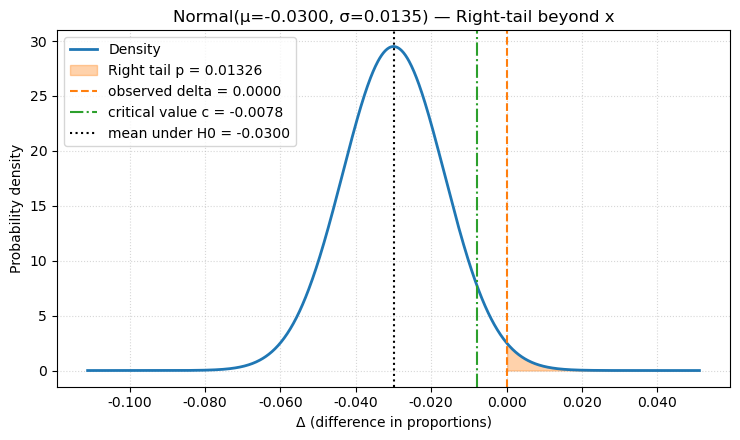

In [6]:
# Plot the Gaussian N(mu, sigma) and shade the right-tail area beyond x

# Use previously defined values; recompute to be robust
SE_H0 = wald_unpooled_SE
mu_H0 = -epsilon
sigma_HO = SE_H0
x0 = hatDelta_realization

# Domain for plotting (±6σ around the mean, clipped to reasonable bounds)
left = mu_H0 - 6 * sigma_HO
right = mu_H0 + 6 * sigma_HO
xs = np.linspace(left, right, 1000)
pdf = norm.pdf(xs, loc=mu_H0, scale=sigma_HO)

# Right-tail probability
p = norm.sf(x0, loc=mu_H0, scale=sigma_HO)

# Critical value at significance alpha (one-sided)
crit_x = norm.ppf(1 - alpha, loc=mu_H0, scale=sigma_HO)

# Plot
fig, ax = plt.subplots(figsize=(7.5, 4.5))
ax.xaxis.set_major_formatter(FormatStrFormatter('%.3f'))
ax.plot(xs, pdf, color="C0", lw=2, label="Density")

# Shade right tail
mask = xs >= x0
ax.fill_between(xs[mask], pdf[mask], color="C1", alpha=0.35, label=f"Right tail p = {p:.4g}")

# Vertical line at observed x
ax.axvline(x0, color="C1", ls="--", lw=1.5, label=f"observed delta = {x0:.4f}")

# Vertical line at critical value
ax.axvline(crit_x, color="C2", ls="-.", lw=1.5, label=f"critical value c = {crit_x:.4f}")

# Vertical line at the mean for the null hypothesis H0
ax.axvline(-epsilon, color="k", ls=":", lw=1.5, label=f"mean under H0 = {-epsilon:.4f}")

# Decorations
ax.set_title(f"Normal(μ={mu_H0:.4f}, σ={sigma_HO:.4f}) — Right-tail beyond x")
ax.set_xlabel("Δ (difference in proportions)")
ax.set_ylabel("Probability density")
ax.legend(loc="best")
ax.grid(True, ls=":", alpha=0.5)
plt.tight_layout()
# plt.show(), display handled by notebook



The traditional ways for NHST to compute the p value is not to use the measurment $\hat{\Delta(w)}$ but to normalize it to a standard normal and centered on zero and on standard deviation 1 N(0,1). This mormalization is done by transforming the measurment into a so called z-score:

The the z-score is just the way you can rescale an arbitrary Gaussian to the Normal by substracting the meand and dividing by the standard deviation $Z = \frac{X-\mu}{\sigma}$

$Z_{NI} = \frac{\hat{\Delta} - (E(\Delta_{H_{boundary}}))}{SE}$ 

$= \frac{\hat{\Delta} - (-\epsilon)}{SE}$ 

$\boxed{Z_{NI}= \frac{\hat{\Delta} + \epsilon}{SE}}$

Then  $\frac{\hat{\Delta} + \epsilon}{SE}$ is a normal N(0,1) and 

$p(\hat{\Delta} \ge \hat{\Delta(w)})$

$ = p(\frac{\hat{\Delta} + \epsilon}{SE} \ge \frac{\hat{\Delta(w) +\epsilon}}{SE })$

Then we can compute the survial function but this timne on a standard normal and from the z-score value

$\int_{ Z_{NI} }^{+\infty} \frac{1}{\sqrt{2 \pi}} e^{-\frac{1}{2}z^2} dz$

which give the exact same results:



In [7]:
zni = (hatDelta_realization + epsilon) / SE_H0
p_zni = norm.sf(zni)
print(f"z_NI: {zni:.4f}, p-value: {p_zni:.4f}")

z_NI: 2.2185, p-value: 0.0133



In the  context of NHST "Positive" means that we rejected the null hypothesis $H_0$ and negative that we did not reject it. So  False positive means we reject $H_0$ given that it was actually holding (was true). So moving to a non inferiority test, it would mean that we reject "is inferior" while it was actually as good or better. This correspond exactly to the decision cutoff rule that is if the probability of the obsevation is below the alpha threshold (say 5%) we reject H_0 (we reject "is inferior" and state "non inferior"). On aveage that rule will deliver the wrong decision 5% of the time is the alpha is set at 0.05. Tthis is the probability of generating a false postive for a non inferiority NHST.

#### Probability of having false negative a.k.a type 2 error , Power and sample size required to get to signficance under those conditions

Conversely , "False negative" in the context of a non inferiority test is the probability of failing to reject given the fact that H1 is true, meaning we fail to clear the non inferiority test, while the new UX is actually non inferior (i.e. as good or better than the old one). So we have the same issue as for the false poistive computation, we have to pick a value for what expected value for the $\Delta$ is under H1, as we cannot really work with a range and we need a single value to fix the gaussian we are going to integrate. Here the same bet it to also pick a boundary which is $E(\Delta) = E(p_C)$ so whatever the control group mean was or is (depending on how much historical data we have)

To model the estimator under the alternative hypothesis H1, we nedd to pick another expected value for the $\Delta$, since this is for H1 which means the same or better, we pick the bare mimium we need to make that statement that is "teh same" and an expectd value of zero fro the Delta. Under these condition we can pool the samples to get an estimator of the variance and standard error as we are assuming they are distributed indentically

$SE | H1 = WaldPooled SE = \sqrt{\hat{p}(\omega_{pool})(1- \hat{p}(\omega_{pool})) (\frac{1}{n_C} + \frac{1}{n_A})}$

With that in place we compute the probabilit of the esimator coming up "higher" but with the same critical value as it was established ahead of time with the significance level alpha.

The Beta is the probability that we observed something lower and up to the the critical value defined but inverting the p-value but under H1, meaning the distribution is centered on the H1 expected value, in our case it is zero.

This computation will give su whatever it gives us, if we want to TARGET a Beta of 0.8, we can conpute the sample sizes (implied in SE) that will make us reach that level.



In [8]:
x = critical_value


In [9]:
SE_H1 = wald_pooled_SE
mu_H1 = 0
sigma_H1 = SE_H1
x = critical_value
beta = norm.cdf(x, loc=mu_H1, scale=sigma_H1)
print(f"Type II error β at critical value {critical_value:.4f}: {beta:.4f}")
power = 1 - beta
print(f"Power (1 - β): {power:.4f}")


Type II error β at critical value -0.0078: 0.2831
Power (1 - β): 0.7169


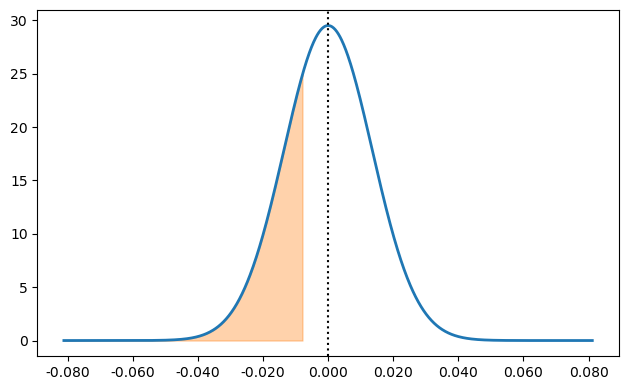

In [10]:

# Domain for plotting (±6σ around the mean, clipped to reasonable bounds)
left = mu_H1 - 6 * sigma_H1
right = mu_H1 + 6 * sigma_H1
xs = np.linspace(left, right, 1000)
pdf = norm.pdf(xs, loc=mu_H1, scale=sigma_H1)
# Plot
fig, ax = plt.subplots(figsize=(7.5, 4.5))
ax.xaxis.set_major_formatter(FormatStrFormatter('%.3f'))
ax.plot(xs, pdf, color="C0", lw=2, label="Density")

# Shade left tail
mask = xs <= critical_value
ax.fill_between(xs[mask], pdf[mask], color="C1", alpha=0.35, label=f"Left tail p = {critical_value:.4g}")

# Vertical line at the mean for the null hypothesis H1
ax.axvline(mu_H1, color="k", ls=":", lw=1.5, label=f"mean under H1 = {mu_H1:.4f}")

In [11]:
import math
from scipy.stats import norm
from scipy.stats import beta


def compute_p_value(x_A, n_A, x_C, n_C):
    """
    Compute the p-value for a one-tailed test where:
      H0: p_A >= p_C  
      H1: p_A < p_C
    using the pooled conversion rate under H0.
    
    Parameters:
        x_A (int): Number of conversions in the variant group.
        n_A (int): Number of visitors in the variant group.
        x_C (int): Number of conversions in the control group.
        n_C (int): Number of visitors in the control group.
        
    Returns:
        p_value (float): The computed one-tailed p-value.
        z (float): The computed z-score (test statistic).
    """
    # Calculate observed conversion rates for variant and control groups
    p_A_hat = x_A / n_A
    p_C_hat = x_C / n_C
    
    # Compute pooled conversion rate under the null hypothesis (p_A = p_C)
    pooled_p = (x_A + x_C) / (n_A + n_C)
    
    # Compute the standard error under H0 using pooled conversion rate
    SE = math.sqrt(pooled_p * (1 - pooled_p) * (1/n_A + 1/n_C))
    
    # Calculate z statistic for the difference in conversion rates.
    # Under H0, z is computed as:
    z = (p_A_hat - p_C_hat) / SE
    
    # Since our alternative H1 is p_A < p_C (variant is worse), we use a one-tailed test.
    # The p-value is the probability that a standard normal variable is below the computed z.
    p_value = norm.cdf(z)
    
    return p_value, z


def decision(x_A, n_A, x_C, n_C, alpha=0.05):
    """
    Make a decision to reject or fail to reject the null hypothesis based on the computed p-value and a given alpha.
    
    Parameters:
        x_A (int): Number of conversions in the variant group.
        n_A (int): Number of visitors in the variant group.
        x_C (int): Number of conversions in the control group.
        n_C (int): Number of visitors in the control group.
        alpha (float): Significance level, default to 0.05.
        
    Returns:
        decision_str (str): A string with the decision and details.
    """
    p_value, z = compute_p_value(x_A, n_A, x_C, n_C)
    
    # Decision based on the p-value compared with the significance level alpha.
    # For a one-tailed test:
    if p_value < alpha:
        decision_str = (
            f"Reject H0: p-value ({p_value:.4f}) is less than alpha ({alpha}).\n"
            f"Test statistic (z) = {z:.4f} indicates the variant conversion rate is significantly lower."
        )
    else:
        decision_str = (
            f"Fail to Reject H0: we will consider the variant \"not worse\", p-value ({p_value:.4f})"  
            f"is more than alpha ({alpha}). meaning the probability of seeing this result is under  the null hypothesis H0 is relatively high\n"
        )
    
    return decision_str



# Example usage:
n_C = 2000  # control group visitors per day
n_A = 200   # variant group visitors per day

# Example conversion counts
x_C = 600  # example: 600 conversions in the control group
x_A = 52   # example: 52 conversions in the variant group

alpha = 0.05 # significance level

d = 0.1

target_power = 0.8

    

p_val, z = compute_p_value(x_A, n_A, x_C, n_C)
print("P-value:", p_val)

result = decision(x_A, n_A, x_C, n_C, alpha)

print(result)


P-value: 0.1187785931193237
Fail to Reject H0: we will consider the variant "not worse", p-value (0.1188)is more than alpha (0.05). meaning the probability of seeing this result is under  the null hypothesis H0 is relatively high



### online calcualtor for sanity checks

https://www.surveymonkey.com/mp/ab-testing-significance-calculator/

https://abtestguide.com/calc/

https://vwo.com/tools/ab-test-significance-calculator/

https://www.graphpad.com/quickcalcs/pvalue1/

In [12]:

def compute_beta_power(x_A, n_A, x_C, n_C, d, alpha=0.05):
    """
    Computes the beta (Type II error rate) and power (1 - beta) for the one-tailed test:
        H0: p_A >= p_C
        H1: p_A < p_C
    assuming a material effect of size d (i.e. the variant conversion rate is lower
    than the control by at least d).
    
    Parameters:
        x_A (int): Conversions in variant group.
        n_A (int): Visitors in variant group.
        x_C (int): Conversions in control group.
        n_C (int): Visitors in control group.
        d (float): Minimum meaningful difference (a positive number, e.g., 0.1).
                   Under H1, we assume p_A_true = p_C - d.
        alpha (float): Significance level (default 0.05).
    
    Returns:
        beta (float): Estimated Type II error rate.
        power (float): Estimated power (1 - beta).
    """
    # Estimate control conversion rate from observed data.
    p_C = x_C / n_C
    # Under alternative, assume variant conversion rate is reduced by d.
    p_A_true = p_C - d
    
    # Standard error under H0 (pooled estimate with p_A = p_C)
    SE0 = math.sqrt(p_C * (1 - p_C) * (1/n_A + 1/n_C))
    # Critical value from the null distribution (one-tailed; left tail)
    # Note: norm.ppf(alpha) is negative (e.g., -1.645 for alpha=0.05)
    D_alpha = norm.ppf(alpha) * SE0

    # Standard error under H1 (using p_C for control and p_A_true for variant)
    SE1 = math.sqrt( (p_C * (1 - p_C) / n_C) + (p_A_true * (1 - p_A_true) / n_A) )
    
    # Under H1, the test statistic D = p_A - p_C is distributed as N( -d, SE1^2 ).
    # We reject H0 if D <= D_alpha.
    # Thus, beta = P( D > D_alpha | H1 )
    # Convert to a standard normal probability:
    beta = 1 - norm.cdf((D_alpha + d) / SE1)
    power = 1 - beta
    return beta, power

def compute_minimum_sample_sizes(x_A, n_A, x_C, n_C, d, target_power, alpha=0.05):
    """
    Estimates the minimum required sample sizes (for the variant and control groups)
    to achieve a desired power, assuming that the ratio between the control and the variant group
    stays constant (i.e., the variant group is a fraction of the control).
    
    The function uses the observed data to estimate the baseline control conversion rate p_C.
    It then assumes that under H1: p_A = p_C - d.
    
    Parameters:
        x_A (int): Conversions in variant group.
        n_A (int): Visitors in variant group.
        x_C (int): Conversions in control group.
        n_C (int): Visitors in control group.
        d (float): Minimum meaningful reduction in conversion rate (positive, e.g., 0.1).
        target_power (float): Desired power (e.g., 0.8).
        alpha (float): Significance level (default 0.05).
        
    Returns:
        n_A_required (float): Minimum required visitors in the variant group.
        n_C_required (float): Minimum required visitors in the control group.
    """
    # Estimate p_C from the observed control group data.
    p_C = x_C / n_C
    # Under alternative, the variant rate is assumed to be:
    p_A_true = p_C - d
    
    # Determine the ratio k = n_C / n_A (using current sample sizes)
    k = n_C / n_A

    # Under H0, the variance factor (without n) is:
    SE0_term = math.sqrt( p_C * (1 - p_C) * ((k + 1) / k) )
    
    # Under H1, the variance factor is:
    SE1_term = math.sqrt( p_C * (1 - p_C) / k + p_A_true * (1 - p_A_true) )
    
    # For a one-tailed test:
    q_alpha = norm.ppf(alpha)           # This is a negative number (e.g., -1.645 for alpha=0.05)
    q_power = norm.ppf(target_power)      # For target power (e.g., 0.84 for 80% power)
    
    # The critical value under H0 is D_alpha = q_alpha * (SE0_term / sqrt(n_A)).
    # Under H1, to have power = target_power, we require:
    #   q_alpha*(SE0_term/√n_A) = -d + q_power*(SE1_term/√n_A)
    # Solving for √n_A yields:
    #   √n_A = ( q_power * SE1_term - q_alpha * SE0_term ) / d
    # (The subtraction sign becomes addition because q_alpha is negative.)
    n_A_required = ((q_power * SE1_term - q_alpha * SE0_term) / d) ** 2
    n_C_required = k * n_A_required
    return n_A_required, n_C_required



# Compute current beta and power using observed data:
beta, power = compute_beta_power(x_A, n_A, x_C, n_C, d, alpha)
print(f"Current beta (Type II error rate): {beta:.4f}")
print(f"Current power (1 - beta): {power:.4f}")

# Compute required minimum sample sizes to achieve the target power:
n_A_req, n_C_req = compute_minimum_sample_sizes(x_A, n_A, x_C, n_C, d, target_power, alpha)
print(f"Minimum required visitors in variant group: {n_A_req:.0f}")
print(f"Minimum required visitors in control group: {n_C_req:.0f}")


Current beta (Type II error rate): 0.0713
Current power (1 - beta): 0.9287
Minimum required visitors in variant group: 132
Minimum required visitors in control group: 1319


### Bayesian Approach

We will assume 2 prior distribution

For the control we have plently of historical data so we can take the historical and/or recent conversion as the baseline, no need to perform statististical inference on it. for the Variant A, assuming we start with an non informative prior (a.k.a uniform prior of) of

$Beta(1,1)$  

With the beta distribuction defined as 
 
representing the prior probability distribution of p_A, meaning that we have no idea, p_A could range from 0 to 1 with equal probability
 
after n trials and k success the posteriod probability distribution due to the property of the Beta function is
 
$Beta(xA +1,n_A − xA+1)$ 

This derived through Bayes Theorem and how the Beta function can be integrated

The expected value for $E(Beta(\alpha,\beta)) = \frac{\alpha}{\alpha + \beta}$

which for a bayesian posterior becomes

$E(Beta(xA+1,nA−xA+1)) = \frac{xA+1}{xA+1 + nA−xA+1} = \frac{xA+1}{nA+2}$

In [31]:
expected_value_posterior = (xA_realization + 1) / (nA + 2)
print(f"Expected value of posterior distribution for p_A: {expected_value_posterior:.4f}")

Expected value of posterior distribution for p_A: 0.2006


In [32]:
# Posterior parameters
alpha = xA_realization + 1
beta_param = nA - xA_realization + 1

# Ensure we use the beta distribution from scipy.stats
from scipy.stats import beta as beta_dist

# Compute 95% credible interval (2.5th and 97.5th percentiles)
p_L = beta_dist.ppf(0.025, alpha, beta_param)
p_U = beta_dist.ppf(0.975, alpha, beta_param)

# Output the result
print(f"95% Credible Interval for p: [{p_L:.4f}, {p_U:.4f}]")

95% Credible Interval for p: [0.1764, 0.2259]


In [33]:
# compute the 99% credible interval (1th and 99th percentiles)
p_L_99 = beta_dist.ppf(0.005, alpha, beta_param)
p_U_99 = beta_dist.ppf(0.995, alpha, beta_param)
# Output the result
print(f"99% Credible Interval for p: [{p_L_99:.4f}, {p_U_99:.4f}]")


99% Credible Interval for p: [0.1692, 0.2343]
